In [1]:
# pytorch

# install pytorch
    # https://pytorch.org/

In [ ]:
# using shell commands in IPython
    # https://jakevdp.github.io/PythonDataScienceHandbook/01.05-ipython-and-shell-commands.html

In [39]:
# imports
import sys, os, datetime, math, time

# data
import numpy as np
import pandas as pd

# pytorch
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms, models

# faster rcnn
from torchvision.models.detection import FasterRCNN, fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pre-processing
from sklearn.model_selection import train_test_split # train test split
from sklearn.preprocessing import MinMaxScaler # scale 0 - 1
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn import metrics #accuracy measure

# images
from IPython.display import Image as IPython_Image, display, clear_output

# PIL
from PIL import Image

# to show images
def show_image(fn, width=500):
    fp1 = os.path.join('./diagrams/', fn)
    display(IPython_Image(filename=fp1, width=width))

In [3]:
# versions
print(
    f"py: {sys.version_info[0:3]}", # sys.version
    f"np: {np.__version__}",
    f"pd: {pd.__version__}",
    f"sns: {sns.__version__}",
    f"torch: {torch.__version__}",
    sep='\n'
)

py: (3, 7, 3)
np: 1.17.3
pd: 0.25.2
sns: 0.9.0
torch: 1.3.1+cpu


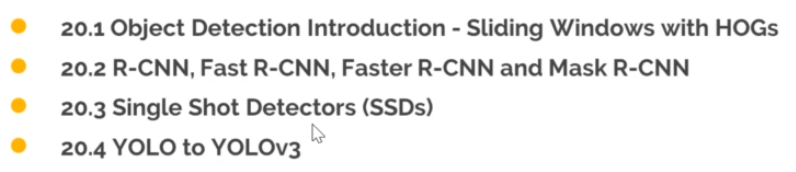

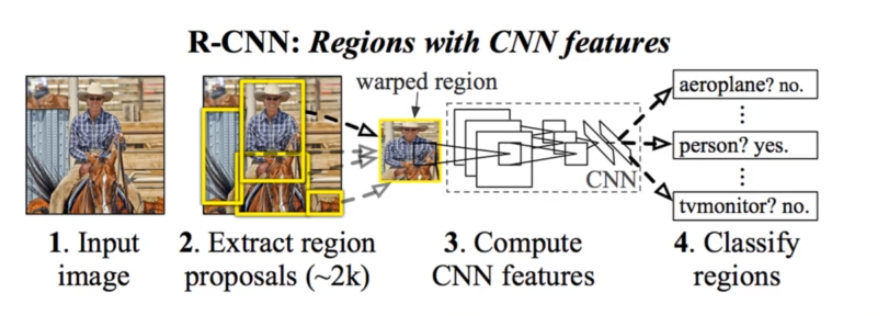

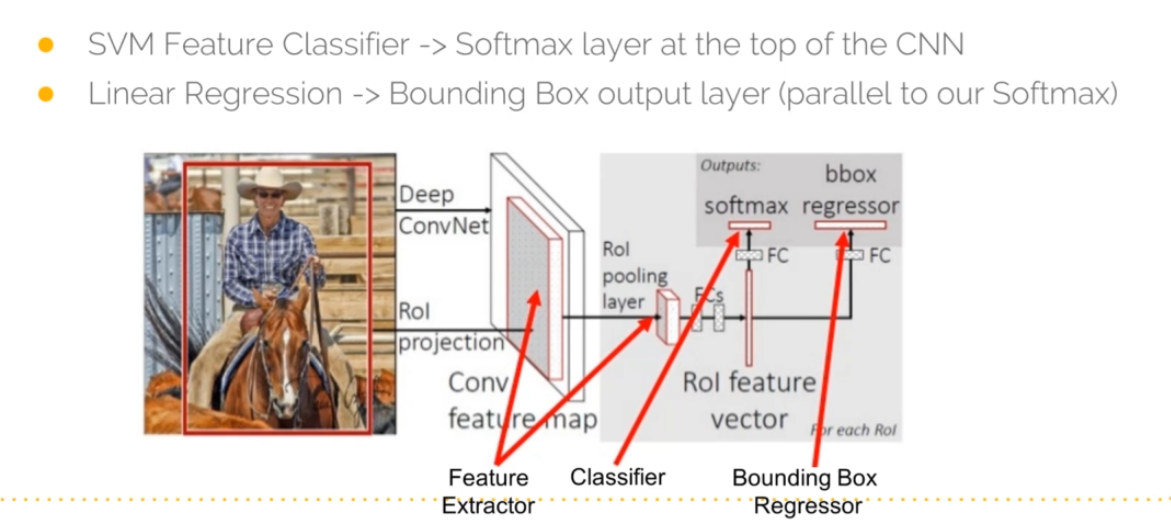

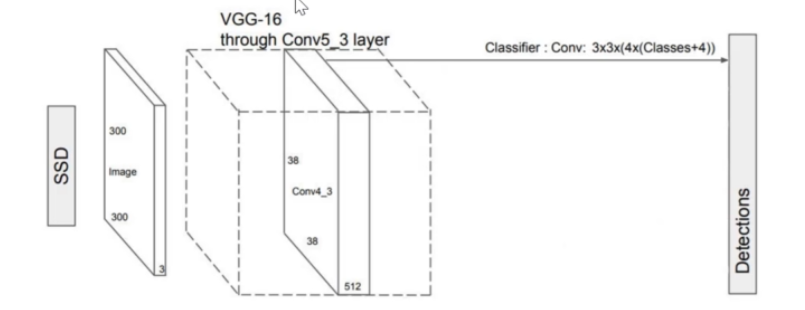

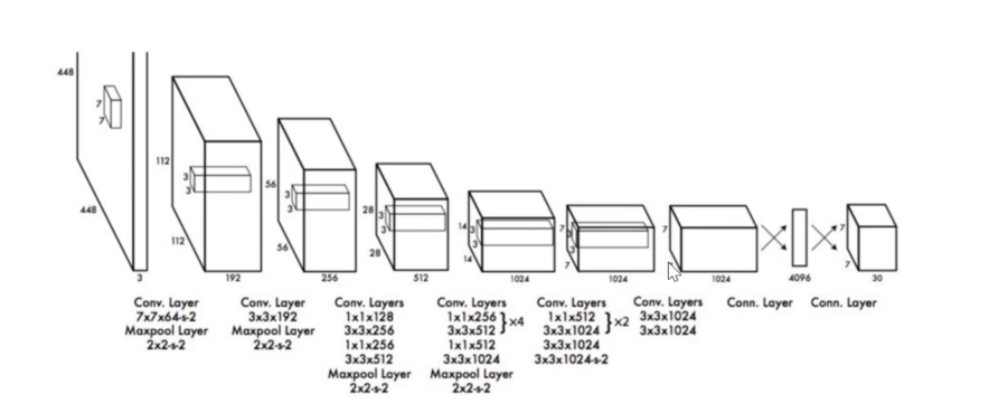

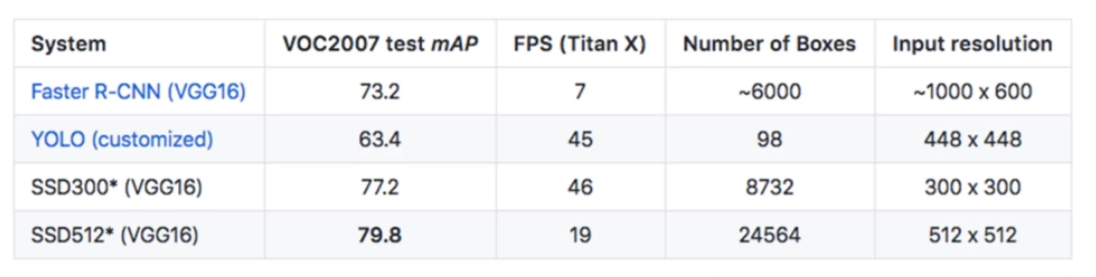

In [18]:
# object detection
    # combination of object classification and localization
    # where is the object? (bounding box)
    
# algorithms
    # https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e
    
# HAAR cascade classifiers
    # first really successful implementation of object detection
    # face detection (viola-jones) (2001)
    # process
        # sliding windows extract segments
        # compute the histogram of gradients (HoG) and how closely it matches object
        # SVMs are typically used to classify HoG features
    # what size window should be used? (is pyramiding robust enough?)
    
# R-CNNs (region convolutional neural networks)
    # propose bounding boxes and pass extracted boxes to a classifier
    # bounding box proposals are done using the "selective search" algorithm
        # "selective search" attempts to segment the image into groups (by color/texture)
        # propose interesting areas
    # interesting regions are passed to a CNN (or SVM) for classification
    # getting a well-fit bounding box:
        # Intersection of Union (IoU) -- measures overlap between 2 boundaries
        # IoU = size of union / size of prediction box
        # good = IoU > 0.5
    # reducing redundant bounding boxes (for the same object):
        # Mean Average Precision (mAP)
        # mAP = (1 / classes) * sum_all_classes( sum_class(t pos) / ( sum_class(t pos) + sum_class(f pos) ) )
    # improve mAP:
        # find max probabilities associated with each box
        # suppress boxes with high overlap (IoU) with high probability boxes
    # steps: (not fast enough for real-time OD)
        # feature extraction CNN
        # SVM to predict class
        # linear regression model to tighten the bounding box
        
# Fast R-CNN
    # reduce number of bounding boxes by removing the overlap generated
    # run CNN across the image just once using a technique called RoI pooling
    # RoIPool allows us to share the forward pass of a CNN (reducing CNN runs to 1).
    # speed bottlenecked by "selective search"

# Faster R-CNN
    # speed up region proposal -- use RPN (region proposal network) instead of selective search.
    # RPN -- fully convolutional netowrk that predicts object bounds and objectness scores
    # trained end-to-end to generate high quality region proposals.
    
# Mask R-CNN
    # combine OD, classification with segmentation
    # Mask output creates binary mask from CNN extracted features
    # uses RoIAlign (instead of RoIpool)
    
# SSD (single shot detector)
    # increase speed by eliminating need for RPN
    # process:
        # feature map extractor (VGG16, replaced by ResNet or DenseNet)
        # convolutional filter for OD
        
# YOLO
    # single neural network applied to full image
    # direct development of MultiBox. 
    # adding a softmax layer in parallel with a box regressor and box classifier layer turns ... 
    # Multibox from region proposal to object recognition method.
    # divides the image into regions and predicts bounding boxes / probabilities for each region.
    # fully convolutional neural network -- allows for various image sizes as input.
    # input image divided into an SxS grid.
    # if center of object is in grid cell, that cell is responsible for detection
    # bounding box defined by x,y,w,h (location of center, width, height)

# YOLOv3
    # better at detecting smaller objects



show_image(fn='detection-algorithms.png')
show_image(fn='rcnn-basic.png')
show_image(fn='fast-rcnn.png')
show_image(fn='ssd-basic.png')
show_image(fn='yolo-architecture.png')
show_image(fn='OD-video.png')

In [34]:
# faster r-cnn (pytorch) (mobilenet_v2)
    # https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py

# training
    # expects the input tensors & targets (list of dictionaries)
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format
        # labels (Int64Tensor[N]): the class label for each ground-truth box
    # returns a Dict[Tensor] during training
        # contains the classification and regression losses for both the RPN and the R-CNN.
    
# testing
    # requires only the input tensors
    # returns predictions as a List[Dict[Per_Tensor]]
    # fields of Dict:
        # boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format
        # labels (Int64Tensor[N]): the predicted labels for each image
        # scores (Tensor[N]): the scores or each prediction
    
# pre-trained model for classification, return features
backbone = models.mobilenet_v2(pretrained=True).features
# output channels in backbone (mobilenet_v2 has 1280)
backbone.out_channels = 1280
# anchor (
    # make RPN generate 5 x 3 anchors per spatial location.
    # 5 different sizes & 3 different aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)
# define feature maps
roi_pooler = MultiScaleRoIAlign(
    featmap_names=[0],
    output_size=7,
    sampling_ratio=2
)
# combine inside FasterRCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)
#
model.eval()
# predict
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

In [29]:
# FasterRCNN (pytorch)(resnet50)

model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/jly36963/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:16<00:00, 9.89MB/s] 


In [37]:
# object detection fine-tuning (theory)
    # pretrained mask-rcnn model (Penn-Fudan db for pedestrian detection and segmentation)
    
# links
    # https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=RoAEkUgn4uEq
    # https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
    

In [38]:
# object detection fine-tuning (preparing dataset)
    
# see example 
'''
Image.open('./data/PennFudanPed/PNGImages/FudanPed00001.png')
mask = Image.open('./data/PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask
'''


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
dataset = PennFudanDataset(root='./data/PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F1720607F60>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [40]:
# object detectiion fine-tuning (fine-tuning a pre-trained model)

# load a model pre-trained pre-trained on COCO
model = fasterrcnn_resnet50_fpn(pretrained=True)
 
# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

['data', 'diagrams', 'models', 'pytorch-detection.ipynb', 'pytorch.ipynb', 'udemy materials']
